Alex Verbs, Kristina Schaufele, Reese Wolfe 

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications


# Loading the Data:

In [5]:
imageDir = "data"

# Subdirectories for datasets
datasets = ['Testing', 'Training']

for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        continue  # Skip if the dataset directory does not exist
    print(f"\nDataset: {dataset}")
    print(f"")
    
    # Get all tumor type directories within the dataset directory
    tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for tumor_type in tumor_types:
        tumor_path = os.path.join(dataset_path, tumor_type)
        
        # List all files (images) in the tumor type directory
        images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
        num_images = len(images)
        
        print(f"  Tumor Type: {tumor_type}, Number of images: {num_images}")
        print(f"")




Dataset: Testing

  Tumor Type: pituitary, Number of images: 300

  Tumor Type: notumor, Number of images: 405

  Tumor Type: glioma, Number of images: 300

  Tumor Type: meningioma, Number of images: 306


Dataset: Training

  Tumor Type: pituitary, Number of images: 1457

  Tumor Type: notumor, Number of images: 1595

  Tumor Type: glioma, Number of images: 1321

  Tumor Type: meningioma, Number of images: 1339




Dataset: Testing
  Tumor Type: pituitary, Number of images: 300
  Tumor Type: notumor, Number of images: 405
  Tumor Type: glioma, Number of images: 300
  Tumor Type: meningioma, Number of images: 306

Dataset: Training
  Tumor Type: pituitary, Number of images: 1457
  Tumor Type: notumor, Number of images: 1595
  Tumor Type: glioma, Number of images: 1321
  Tumor Type: meningioma, Number of images: 1339


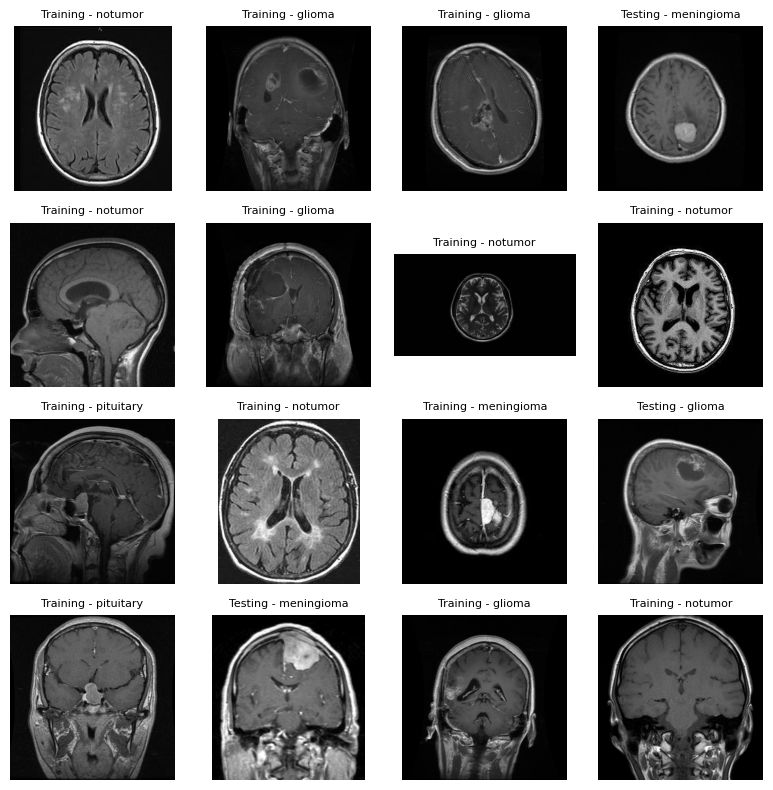

In [6]:
import random

# Collect sample images and their labels
sample_images = []
labels = []

for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        print(f"Dataset directory not found: {dataset_path}")
        continue  # Skip if the dataset directory does not exist
    print(f"\nDataset: {dataset}")
    
    # Get all tumor type directories within the dataset directory
    tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for tumor_type in tumor_types:
        tumor_path = os.path.join(dataset_path, tumor_type)
        
        # List all files (images) in the tumor type directory
        images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
        num_images = len(images)
        
        print(f"  Tumor Type: {tumor_type}, Number of images: {num_images}")
        
        if num_images == 0:
            print(f"  No images found in {tumor_path}")
            continue  # Skip to the next tumor type if no images are found
        
        # Add all images from each tumor type to the sample lists
        for image_file in images:
            image_path = os.path.join(tumor_path, image_file)
            sample_images.append(image_path)
            labels.append(f"{dataset} - {tumor_type}")

# Randomize the collected images
combined_data = list(zip(sample_images, labels))
random.shuffle(combined_data)

# Limit to 16 random images
sample_images, labels = zip(*combined_data[:16])

# Display images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to make images smaller or larger
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for idx, ax in enumerate(axes):
    if idx < len(sample_images):
        image_path = sample_images[idx]
        img = mpimg.imread(image_path)
        ax.imshow(img, cmap='gray')
        ax.set_title(labels[idx], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide any unused subplots

plt.tight_layout()
plt.show()

In [7]:
# Parameters
img_height = 180  # Set your desired image height
img_width = 180   # Set your desired image width
batch_size = 32   # Set your desired batch size

# Directory paths for training and testing
train_dir = "data/Training"
test_dir = "data/Testing"

# Load the training dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load the testing dataset
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    shuffle = False,
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# Baseline Accuracy

In [8]:

class_counts = {'notumor': 0, 'glioma': 0, 'meningioma': 0, 'pituitary': 0}
dataset_path = os.path.join(imageDir, 'Training')

print(f"\nDataset: {'Training'}")
print(f"")

# Get all tumor type directories within the dataset directory
tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
for tumor_type in tumor_types:
    tumor_path = os.path.join(dataset_path, tumor_type)
    
    # List all files (images) in the tumor type directory
    images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
    num_images = len(images)
    
        # Adjust class names as per your folder names
    if "notumor" in tumor_type:
        class_counts['notumor'] += num_images
    elif "glioma" in tumor_type:
        class_counts['glioma'] += num_images
    elif "meningioma" in tumor_type:
        class_counts['meningioma'] += num_images
    elif "pituitary" in tumor_type:
        class_counts['pituitary'] += num_images

    # Print the class counts before calculating baseline accuracy
print("Class Counts:", class_counts)

# Calculate baseline accuracy for subtypes
total_images = class_counts['notumor'] + class_counts['glioma'] + class_counts['meningioma'] + class_counts['pituitary']
majority_class_count = max(class_counts.values())
baseline_accuracy = majority_class_count / total_images

print(f"Baseline Accuracy for 4 Categories: {baseline_accuracy:.2%}")

# Calculate baseline accuracy for subtypes
total_tumors = class_counts['glioma'] + class_counts['meningioma'] + class_counts['pituitary']
no_tumors = class_counts['notumor']
binary_baseline_accuracy = total_tumors/ total_images
print(f"Baseline Accuracy for 2 Categories: {binary_baseline_accuracy:.2%}")



Dataset: Training

Class Counts: {'notumor': 1595, 'glioma': 1321, 'meningioma': 1339, 'pituitary': 1457}
Baseline Accuracy for 4 Categories: 27.92%
Baseline Accuracy for 2 Categories: 72.08%


# Transfer learning with ResNet

In [9]:
# Load a pretrained ResNet50 model, excluding the top layer
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Resizing(224, 224),  # ResNet50 expects 224x224 images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # Final layer with softmax for classification
])


# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



NameError: name 'dropout_rate_2' is not defined

# Transfer learning with ResNet, Dropout, and Early Stopping

In [11]:
# Load a pretrained ResNet50 model, excluding the top layer
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Resizing(224, 224),  # ResNet50 expects 224x224 images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')  # Final layer with softmax for classification
])


# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss to stop on
    patience=3,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[early_stopping]  
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.7038 - loss: 2.7039 - val_accuracy: 0.8604 - val_loss: 0.3597
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8755 - loss: 0.3307 - val_accuracy: 0.8780 - val_loss: 0.3010
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9019 - loss: 0.2537 - val_accuracy: 0.9077 - val_loss: 0.2742
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.8884 - loss: 0.2926 - val_accuracy: 0.8970 - val_loss: 0.2738
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.9054 - loss: 0.2537 - val_accuracy: 0.8558 - val_loss: 0.4137
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8945 - loss: 0.2831 - val_accuracy: 0.9222 - val_loss: 0.2594
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1043s 6s/step - accuracy: 0.9078 - loss: 0.2555 - val_accuracy: 0.9222 - val_loss: 0.2075
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 8201s 46s/step - accuracy: 0.9102 - loss: 0.2394 - val_a

# Confusion Matrix for Transfer learning with ResNet, Dropout, and added Early Stopping

In [12]:
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(train_ds)
print(f"Training Accuracy: {accuracy * 100:.2f}%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,164,430 (95.99 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,051,146 (4.01 MB)

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 973ms/step - accuracy: 0.9112 - loss: 0.2319
Test Accuracy: 93.59%
179/179 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9640 - loss: 0.0927
Training Accuracy: 96.80%


2024-11-24 19:11:04.694475: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
Sample true labels: [0 0 0 0 0 0 0 0 0 0]
Sample predicted labels: [0 0 0 0 0 0 0 0 0 0]
Manual Testing Accuracy: 0.9359267734553776


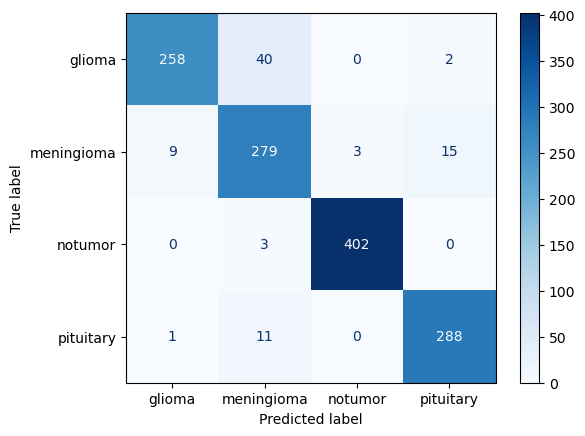


Per-Class Accuracy:
  notumor: 86.00%
  glioma: 91.18%
  meningioma: 99.26%
  pituitary: 96.00%


'\n# Plot the confusion matrix using Matplotlib\nplt.figure(figsize=(10, 8))\nplt.imshow(conf_matrix, interpolation=\'nearest\', cmap=\'Blues\')\nplt.title("Confusion Matrix for CNN")\nplt.colorbar()\n\n# Label the axes with the custom class names\nnum_classes = len(class_names)\nplt.xticks(np.arange(num_classes), labels=class_names)\nplt.yticks(np.arange(num_classes), labels=class_names)\nplt.xlabel("Predicted Labels")\nplt.ylabel("True Labels")\n\n# Add counts to each cell in the matrix\nfor i in range(num_classes):\n    for j in range(num_classes):\n        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")\n\n'

In [13]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Define the class labels based on tumor type
class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Extract true labels from `test_ds`
y_true = np.concatenate([y for x, y in test_ds], axis=0) # Add the class labels directly to the list
y_true = np.array(y_true)  # Convert list to NumPy array

# Predict using the model on the test dataset
y_pred = np.argmax(model.predict(test_ds), axis=-1)  # Convert each batch to NumPy and add to list
y_pred = np.array(y_pred)  # Convert list to NumPy array

# Check if sample shapes match
print("Sample true labels:", y_true[:10])
print("Sample predicted labels:", y_pred[:10])

# Calculate manual accuracy
accuracy_manual = np.mean(y_true == y_pred)
print("Manual Testing Accuracy:", accuracy_manual)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Compute per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nPer-Class Accuracy:")
for class_name, accuracy in zip(class_names, per_class_accuracy):
    print(f"  {class_name}: {accuracy * 100:.2f}%")

"""
# Plot the confusion matrix using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.colorbar()

# Label the axes with the custom class names
num_classes = len(class_names)
plt.xticks(np.arange(num_classes), labels=class_names)
plt.yticks(np.arange(num_classes), labels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Add counts to each cell in the matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

"""


# Network: Trained ResNet, Dropout, and added Early Stopping

In [14]:
# Load a pretrained ResNet50 model, excluding the top layer
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Freeze all layers initially

# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = True

# Build the model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Resizing(224, 224),  # ResNet50 expects 224x224 images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')  # Final layer with softmax for classification
])


# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss to stop on
    patience=3,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[early_stopping]  
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 6671s 37s/step - accuracy: 0.3630 - loss: 4.2193 - val_accuracy: 0.3143 - val_loss: 419.1960
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1263s 7s/step - accuracy: 0.5174 - loss: 1.0630 - val_accuracy: 0.4935 - val_loss: 1.1052
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 7344s 41s/step - accuracy: 0.5491 - loss: 1.0116 - val_accuracy: 0.4645 - val_loss: 2.1315
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 5703s 32s/step - accuracy: 0.6490 - loss: 0.8294 - val_accuracy: 0.4111 - val_loss: 1.9028
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1135s 6s/step - accuracy: 0.7017 - loss: 0.7154 - val_accuracy: 0.5454 - val_loss: 1.1725
41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4593 - loss: 1.2348
Test Accuracy: 49.35%


In [15]:
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(train_ds)
print(f"Training Accuracy: {accuracy * 100:.2f}%")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,233,614 (275.55 MB)

 Trainable params: 24,060,164 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,120,330 (183.56 MB)

41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4593 - loss: 1.2348
Test Accuracy: 49.35%
179/179 ━━━━━━━━━━━━━━━━━━━━ 1093s 6s/step - accuracy: 0.5587 - loss: 0.9969
Training Accuracy: 54.90%
